In [1]:
import instruments as inst
import copy
import numpy as np
import json

# Step 1.a): Reading in csv - extracting single diffs and sums and configurations

In [2]:
file_path = "20230914_processed_table.csv"
wavelength_string = 720
obs_mode = "MBI"

interleaved_values, interleaved_stds, configuration_list = inst.read_csv(file_path, 
    obs_mode = obs_mode, obs_filter = wavelength_string)
print("Interleaved Values")
print("Length: ", len(interleaved_values))
print(interleaved_values)
print("Interleaved Stds")
print("Length: ", len(interleaved_stds))
print(interleaved_stds[0 : 10])
print("Configuration List")
print("Length: ", len(configuration_list))
print(configuration_list)
print(interleaved_stds[0])

Interleaved Values
Length:  320
[ 19443.    27359.5  -26523.5   29186.    10360.5   27538.5  -17840.5
  28326.   -10662.5   28418.5    3473.    27876.   -27267.5   29836.5
  21314.    27976.5  -27920.5   29951.5   23421.5   28214.   -12034.
  28774.     8556.    28492.5   10305.5   27996.5  -13423.    29077.
  21867.    27914.   -25387.5   29809.5   14391.5   28174.   -20535.5
  29352.5   20802.5   27697.   -27617.    29505.     9551.    28000.5
 -17167.5   28696.   -12391.5   28871.5    4892.5   28166.   -28211.
  30113.5   21892.5   28098.5  -27316.    29949.    22458.    28215.
 -10273.    28577.5    6538.5   28392.    11477.    27759.   -14727.5
  28943.     -867.5   29043.    -3647.    29198.    18165.5   28361.5
 -23641.    29681.5   22278.    28083.   -28827.    29929.     8984.
  28448.   -16566.    29038.   -13928.    29321.5    6282.    28442.5
 -28623.5   30393.    22020.    28267.5  -26182.    30032.    20955.
  28281.    -8140.    28472.     3993.5   28344.5  -16823.    29

# Step 1.b) - Make plot of existing values as double diffs and sums

# Step 2: Creating a system Mueller matrix object

In [3]:
# Loading in previous fit from vampires_calibration
filename = "725-50_restrictive_HWP_FLC_no_IMR_offset_with_dichroic_best_fit_old_fit_values.txt"
with open(filename, "r") as f:
    past_fit = json.load(f)

print(past_fit)

theta_pol = past_fit["lp"]["theta"]
delta_HWP = past_fit["hwp"]["phi"] 
offset_HWP = past_fit["hwp"]["delta_theta"]
delta_derot = past_fit["image_rotator"]["phi"] 
delta_opts = past_fit["optics"]["phi"]
epsilon_opts = past_fit["optics"]["epsilon"]
rot_opts = past_fit["optics"]["theta"]
delta_FLC = past_fit["flc"]["phi"] 
rot_FLC = past_fit["flc"]["delta_theta"]
em_gain = past_fit["wollaston"]["transmission_ratio"]

# Based on values in Six_And_Eleven_Parameter_Model_Best_MCMC_and_Scipy_Fits Google Sheets - having zeros for angles that're too large
# theta_pol = 0
# delta_HWP = 0.451  # Add your actual delta_HWP value
# offset_HWP = -2.642  # Add your actual offset_HWP value
# delta_derot = 0.32  # Add your actual delta_derot value
# offset_derot = 0  # Add your actual offset_derot value
# delta_opts = 0  # Add your actual delta_opts value
# epsilon_opts = 0  # Add your actual epsilon_opts value
# rot_opts = 0  # Add your actual rot_opts value
# delta_FLC = 0.5  # Add your actual delta_FLC value
# rot_FLC = 0  # Add your actual rot_FLC value
# em_gain = 1.2  # Add your actual em_gain value

# NOTE: Components must be listed downstream to upstream
# Define the instrument configuration as a system dictionary
system_dict = {
    "components": {
        "wollaston": {
            "type": "wollaston_prism_function",
            "properties": {"beam": "o", "transmission_ratio": em_gain},
        },
        "dichroic": {
            "type": "diattenuator_retarder_function",
            "properties": {"phi": 0, "epsilon": 0, "theta" : 0},
        },
        "flc": {
            "type": "general_retarder_function",
            "properties": {"phi": delta_FLC, "theta": 0, "delta_theta": rot_FLC},
        },
        "optics": {
            "type": "diattenuator_retarder_function",
            "properties": {"phi": delta_opts, "epsilon": epsilon_opts, "theta": rot_opts},
        },
        "image_rotator": {
            "type": "general_retarder_function",
            "properties": {"phi": delta_derot, "theta": 0, "delta_theta": 0},
        },
        "hwp": {
            "type": "general_retarder_function",
            "properties": {"phi": delta_HWP, "theta": 0, "delta_theta": offset_HWP},
        },
        "lp": {
            "type": "general_linear_polarizer_function_with_theta",
            "properties": {"theta": theta_pol},
        }
    }
}

{'wollaston': {'transmission_ratio': 1.1564212957789048}, 'dichroic': {'phi': -0.008993624414963179, 'epsilon': 0.018482389580569993, 'theta': -0.007172417325267794}, 'flc': {'phi': 3.254754164606743, 'delta_theta': 4.071337175892329}, 'optics': {'phi': 0.5510028665782447, 'epsilon': 0.0039349157627214795, 'theta': -39.73119225284772}, 'image_rotator': {'phi': 2.8936096290210673}, 'hwp': {'phi': 3.0347536196537543, 'delta_theta': 3.409809501718911}, 'lp': {'theta': 4.999999960094904}}


In [4]:
# Converting system dictionary into system Mueller Matrix object

system_mm = inst.generate_system_mueller_matrix(system_dict)
print(system_mm.evaluate())

[[0.51597258 0.5081338  0.0895977  0.        ]
 [0.51597258 0.5081338  0.0895977  0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


# Step 4: Creating a dictionary of p0 starting guesses

logl value: 3693.9999479301387


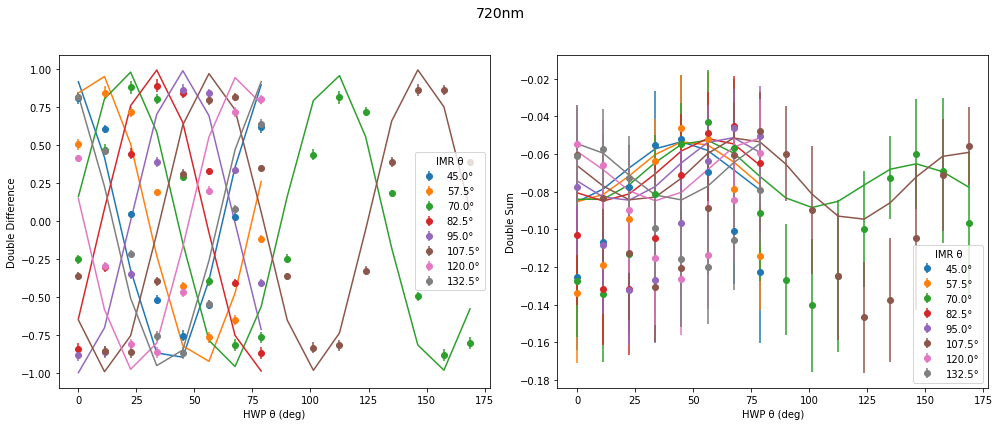

In [5]:
# Fittin for all parameters

bounds = [ 
    # (0, 2),  # em_gain
    (-2 * np.pi, 2 * np.pi), # dichroic_retardance
    (0, 1), # dichroic_diattenuation
    (-90, 90), # dichroic_rotation_angle 
    # (0.4 * 2 * np.pi, 0.6 * 2 * np.pi),  # delta_FLC
    # (-5, 5),  # rot_FLC
    (-np.pi, np.pi),  # delta_opts
    (0, 0.1),  # epsilon_opts
    (-90, 90),  # rot_opts
    # ((delta_derot - delta_derot * 0.1) * 2 * np.pi, (delta_derot + delta_derot * 0.1) * 2 * np.pi),  # delta_derot
    # (-1, 1),  # offset_derot
    # ((delta_HWP - delta_HWP * 0.1) * 2 * np.pi, 0.5 * 2 * np.pi),  # delta_HWP
    # (-5, 5),  # offset_HWP
    # (-5, 5),  # theta_pol
]

p0 = {
    'dichroic': {'phi': 0, 'epsilon': 0, 'theta': 0}, 
     'optics': {'phi': 0, 'epsilon': 0, 'theta': 0}
    }

p0_values, p0_keywords = inst.parse_configuration(p0)
s_in = np.array([1, 0, 0, 0])
logl_value = inst.logl(p0_values, p0_keywords, system_mm, interleaved_values, interleaved_stds, configuration_list,
    s_in=s_in, logl_function=None, process_dataset=inst.process_dataset, process_errors=inst.process_errors, 
    process_model=inst.process_model)
print("logl value: " + str(logl_value))

# TODO: Add an initial plot block here
# Plotting intial plot
updated_system_mm = inst.update_system_mm(p0_values, p0_keywords, system_mm)
model = inst.model(p0_values, p0_keywords, system_mm, configuration_list, 
    process_model = inst.process_model)

inst.plot_data_and_model(interleaved_values, interleaved_stds, model, 
    configuration_list, wavelength = wavelength_string)

# Step 5: Running minimize_system_Mueller_matrix iteratively

Before p0: {'dichroic': {'phi': 0, 'epsilon': 0, 'theta': 0}, 'optics': {'phi': 0, 'epsilon': 0, 'theta': 0}}


Iteration #: 1
logl_value: 182.2982621442471
Best Fit Parameters: [ -2.99551578   0.0187007    2.48592565   0.96786584   0.
 -10.1336934 ]


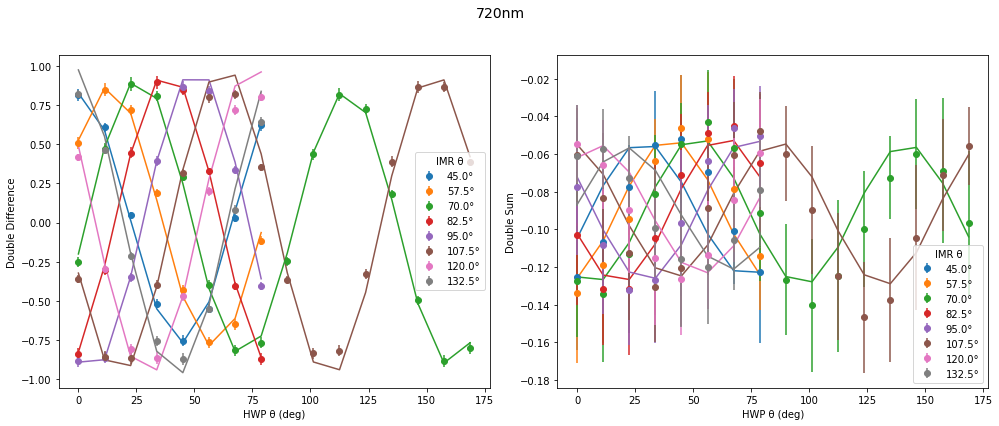

After p0: {'dichroic': {'phi': -2.995515783116094, 'epsilon': 0.01870069708044832, 'theta': 2.4859256464687354}, 'optics': {'phi': 0.9678658373049807, 'epsilon': 0.0, 'theta': -10.133693401448618}}
Before p0: {'dichroic': {'phi': -2.995515783116094, 'epsilon': 0.01870069708044832, 'theta': 2.4859256464687354}, 'optics': {'phi': 0.9678658373049807, 'epsilon': 0.0, 'theta': -10.133693401448618}}
Iteration #: 2
logl_value: 170.4205638266656
Best Fit Parameters: [ -3.1178456    0.0188259    2.98974421   0.77327592   0.02774893
 -15.25512193]


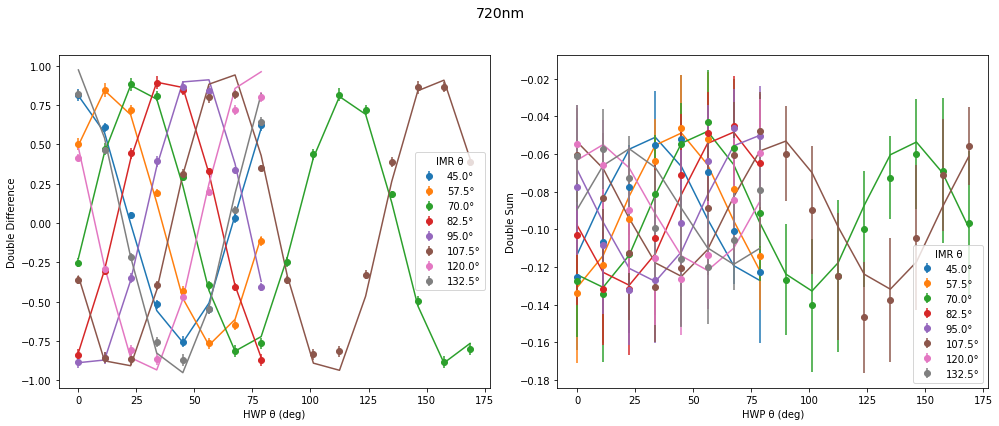

After p0: {'dichroic': {'phi': -3.1178456042358773, 'epsilon': 0.018825897417551633, 'theta': 2.9897442100434226}, 'optics': {'phi': 0.7732759178730679, 'epsilon': 0.027748926718177955, 'theta': -15.255121932122261}}
Before p0: {'dichroic': {'phi': -3.1178456042358773, 'epsilon': 0.018825897417551633, 'theta': 2.9897442100434226}, 'optics': {'phi': 0.7732759178730679, 'epsilon': 0.027748926718177955, 'theta': -15.255121932122261}}
Iteration #: 3
logl_value: 170.4205638266656
Best Fit Parameters: [ -3.1178456    0.0188259    2.98974421   0.77327592   0.02774893
 -15.25512193]


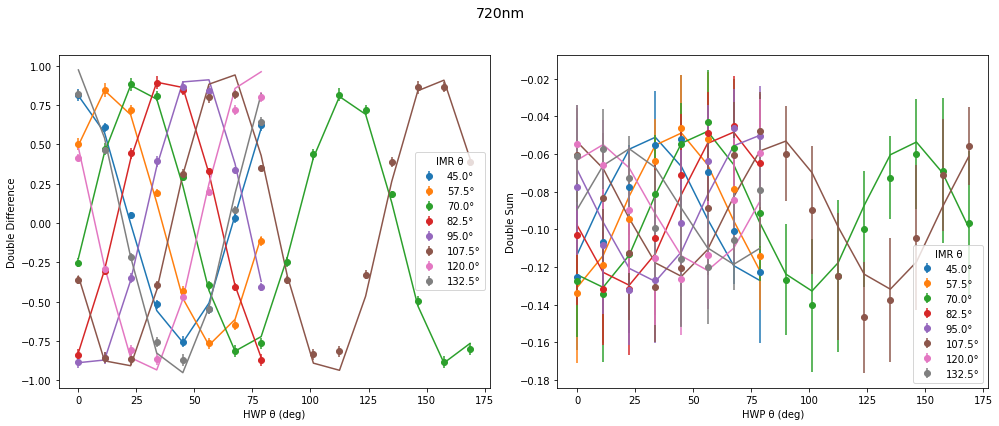

After p0: {'dichroic': {'phi': -3.1178456042358773, 'epsilon': 0.018825897417551633, 'theta': 2.9897442100434226}, 'optics': {'phi': 0.7732759178730679, 'epsilon': 0.027748926718177955, 'theta': -15.255121932122261}}


In [6]:
# Unpolarized light for s_in as there is LP in the system already
s_in = np.array([1, 0, 0, 0])

# Counters for iterative fitting
iteration = 1
previous_logl_value = 1000000
new_logl_value = 0

while abs(previous_logl_value - new_logl_value) > 0.01 * abs(previous_logl_value):
    print("Before p0: " + str(p0))
    if iteration > 1: 
        previous_logl_value = new_logl_value
    result, new_logl_value = inst.minimize_system_mueller_matrix(p0, system_mm, 
        interleaved_values, interleaved_stds, configuration_list, s_in = s_in,
        process_dataset = inst.process_dataset, 
        process_errors = inst.process_errors, 
        process_model = inst.process_model, bounds = bounds)
    
    # Print statements
    print("Iteration #: " + str(iteration))
    print("logl_value: " + str(new_logl_value))
    print("Best Fit Parameters: " + str(result.x))

    # Making a plot
    updated_system_mm = inst.update_system_mm(result.x, p0_keywords, system_mm)
    model = inst.model(result.x, p0_keywords, updated_system_mm, configuration_list, 
    process_model = inst.process_model)

    inst.plot_data_and_model(interleaved_values, interleaved_stds, model, 
        configuration_list, wavelength = wavelength_string)

    # Updating p0 for next time
    inst.update_p0(p0, result.x)
    print("After p0: " + str(p0))

    iteration += 1

    filename = f"{wavelength_string}_no_IMR_offset_with_dichroic_best_fit_old_fit_values.txt"
    with open(filename, 'w') as f:
        json.dump(p0, f, indent=4)

# Step 6: Plot model with best fit

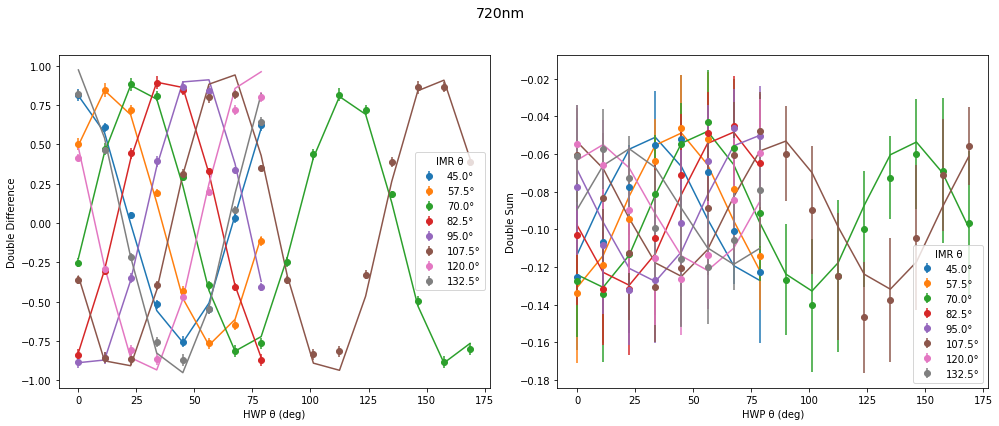

In [7]:
# Generate model with p0 keywords but scipy minimized results
# print(result.x)
# print(p0_keywords)

# Manually adjusting for a good fit
dichroic_phi = 0 # (waves)
dichroic_theta = 0 # (degrees)
# result.x = [2 * np.pi * dichroic_phi, dichroic_theta]

updated_system_mm = inst.update_system_mm(result.x, p0_keywords, system_mm)
model = inst.model(result.x, p0_keywords, system_mm, configuration_list, 
    process_model = inst.process_model)

inst.plot_data_and_model(interleaved_values, interleaved_stds, model, 
    configuration_list, wavelength = wavelength_string)